In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from matplotlib.animation import FFMpegWriter
from tensorflow.keras.callbacks import Callback

plt.style.use('dark_background')

import random 

In [2]:

# Function to generate Taylor polynomial series feature vector (not considering derivative and center is 0)

def taylor_series_features(input_array, degree):
    taylor_features = []
    for x in input_array:
        features = [x ** i for i in range(degree + 1)]
        taylor_features.append(features)
    return np.array(taylor_features)


In [3]:
def outputFunction(input_array):
    # define your function values here in form of output array
    output_array = np.array([np.sin(2 * x) - np.cos(x) for x in input_array])

    function_name = "sin2x-cosx"

    return output_array, function_name

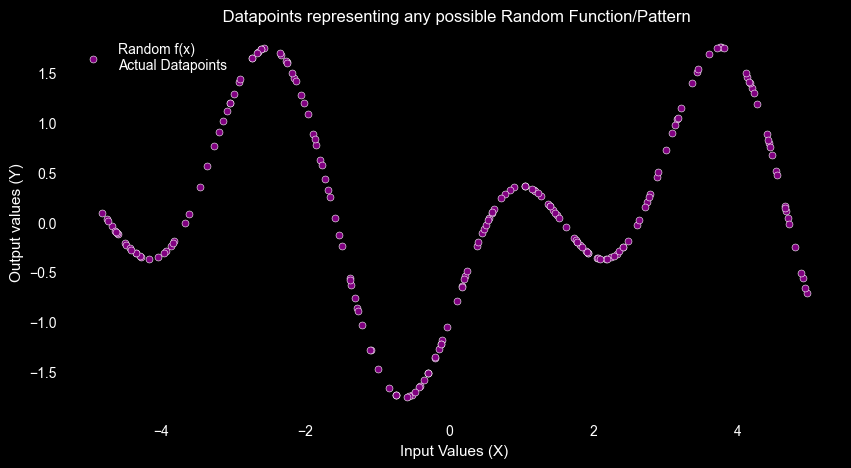

In [15]:

# Generate synthetic data 
np.random.seed(42)
input_array = np.array([random.uniform(-5,5) for _ in range(200)])
output_array, function_name = outputFunction(input_array)


input_array_reshaped = input_array.reshape(-1,1)
output_array_reshaped = output_array.reshape(-1, 1) 

plt.figure(figsize=(10,5))
sns.scatterplot(x=input_array, y=output_array, color="purple", label="Random f(x)\nActual Datapoints", s=25)
plt.title(" Datapoints representing any possible Random Function/Pattern")
plt.xlabel("Input Values (X)")
plt.ylabel("Output values (Y)")
plt.grid(visible=False)
plt.show()

In [16]:

# Convert input array to Taylor series feature vector
degree = 3
taylor_features = taylor_series_features(input_array, degree)
taylor_features = np.array(taylor_features)


In [17]:

# Create and compile the neural network model
model = Sequential([
    Dense(16, input_shape=(degree+1,), activation= 'relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


c:\Users\thaku\anaconda3\envs\ml_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,553 (37.32 KB)

 Trainable params: 9,553 (37.32 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
print(taylor_features.shape)
print(taylor_features[:2])  # Print the first two rows for inspection

(200, 4)
[[ 1.          3.76900763 14.20541849 53.54033064]
 [ 1.         -0.98954166  0.97919269 -0.96895196]]


In [20]:
class SaveLinePlotCallback(Callback):
    def __init__(self, input_features, output_array, output_dir):
        self.input_features = input_features  
        self.output_array = output_array.flatten()
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        # Generate predictions
        pred_values = self.model.predict(self.input_features).flatten()

        # Plot actual vs predicted values
        plt.figure(figsize=(9, 6))
        sns.scatterplot(x=input_array, y=self.output_array, label="Actual datapoints", color = 'purple', s=22)  
        sns.lineplot(x=input_array, y=pred_values, label="Model Learning curve", color='lightblue')
        plt.xlabel("Input Feature (X)")
        plt.ylabel("Output Value (Y)")
        plt.title(f"Learning progress (Taylor Series-FM) (Epoch {epoch + 1}), (Loss: {logs['loss']:.4f})")
        plt.legend()
        plt.grid(visible=False)

        plt.xlim(min(input_array)-1, max(input_array)+1)
        plt.ylim(min(output_array)-1, max(output_array)+1)

        # Save the plot as an image
        img_name = (f"0{epoch}" if epoch<10 else f"{epoch}")
        file_path = os.path.join(self.output_dir, f'Taylor_lineplot_epoch_{img_name}.png')
        plt.savefig(file_path)
        plt.close()


In [21]:
output_dir = "epoch_lineplots_taylor"

save_lineplot_callback = SaveLinePlotCallback(
    input_features=taylor_features,
    output_array=output_array_reshaped,
    output_dir=output_dir
)

# Train the model
history = model.fit(
    taylor_features,
    output_array_reshaped,
    epochs=60,
    batch_size=8,
    callbacks=[save_lineplot_callback]
)

print(f"Line plots for each epoch saved in '{output_dir}'")


Epoch 1/60


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 0.3558 - mae: 0.5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6323 - mae: 0.6553
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step   - loss: 0.3763 - mae: 0.535
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5115 - mae: 0.5629
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - loss: 0.5706 - mae: 0.631
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4181 - mae: 0.5189
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - loss: 0.1711 - mae: 0.3522
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2512 - mae: 0.3954
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - loss: 0.1453 - mae: 0.309
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1719 - mae: 0.3235
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - loss: 0.1749 - mae: 0.338
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1272 - mae: 0.2778
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - loss: 0.0327 - mae: 0.145
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0415 - mae: 

In [22]:
# Create a video from the saved images
def create_video_from_images(image_dir, video_name, fps=2):
    images = sorted([img for img in os.listdir(image_dir)])
    frame = cv2.imread(os.path.join(image_dir, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_dir, image)))

    cv2.destroyAllWindows()
    video.release()

# Generate video
video_name = f"training_progress_taylor_{function_name}.mp4"
create_video_from_images(output_dir, video_name, fps=2)

print(f"Video saved as '{video_name}'")


Video saved as 'training_progress_taylor_sin2x-cosx.mp4'
